In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
# Membaca data dari CSV
colors_df = pd.read_csv('colors.csv')


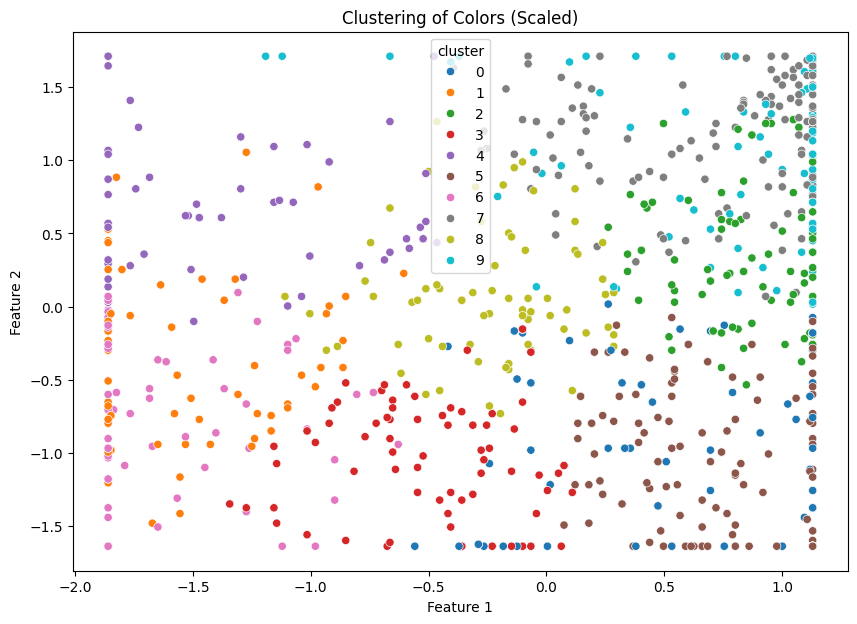

In [3]:
# Menyiapkan data RGB dan Normalisasi
rgb_values = colors_df[['r', 'g', 'b']].values
scaler = StandardScaler()
rgb_values_scaled = scaler.fit_transform(rgb_values)

# Menggunakan K-Means untuk mengelompokkan warna dengan inisialisasi k-means++
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42)
kmeans.fit(rgb_values_scaled)

# Menambahkan label cluster ke DataFrame
colors_df['cluster'] = kmeans.labels_

# Visualisasi hasil clustering
plt.figure(figsize=(10, 7))
sns.scatterplot(x=rgb_values_scaled[:, 0], y=rgb_values_scaled[:, 1], hue=colors_df['cluster'], palette='tab10')
plt.title('Clustering of Colors (Scaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


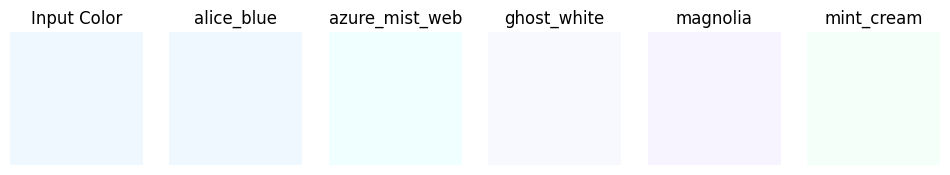

In [7]:
# Menggunakan Nearest Neighbors untuk mencari warna yang paling mirip
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(rgb_values_scaled)

# Fungsi untuk mendapatkan rekomendasi warna berdasarkan input RGB
def get_color_recommendations(input_rgb, n_recommendations=5):
    input_rgb_scaled = scaler.transform([input_rgb])
    distances, indices = nbrs.kneighbors(input_rgb_scaled)
    recommended_colors = colors_df.iloc[indices[0]]
    return recommended_colors

# Contoh penggunaan fungsi rekomendasi
input_rgb = [240, 248, 255]  # Warna input contoh
recommended_colors = get_color_recommendations(input_rgb)

# Visualisasi warna input dan rekomendasi
def plot_color_recommendations(input_rgb, recommended_colors):
    plt.figure(figsize=(12, 2))
    
    # Warna input
    plt.subplot(1, 6, 1)
    plt.imshow([[input_rgb]])
    plt.title('Input Color')
    plt.axis('off')

        # Warna rekomendasi
    for i, (_, row) in enumerate(recommended_colors.iterrows()):
        plt.subplot(1, 6, i + 2)
        plt.imshow([[(row['r'], row['g'], row['b'])]])
        plt.title(row['color_name'])
        plt.axis('off')
    
    plt.show()

# Plot warna input dan rekomendasi
plot_color_recommendations(input_rgb, recommended_colors)

In [8]:
# Simpan model K-Means
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Simpan model Nearest Neighbors
with open('nearest_neighbors_model.pkl', 'wb') as f:
    pickle.dump(nbrs, f)

In [9]:
# Menghitung Silhouette Score
sil_score = silhouette_score(rgb_values_scaled, kmeans.labels_)
print(f'Silhouette Score for K-Means Clustering: {sil_score:.2f}')

# Menghitung Inertia dari K-Means
print(f'Inertia: {kmeans.inertia_:.2f}')

Silhouette Score for K-Means Clustering: 0.29
Inertia: 523.80


In [10]:
# Fungsi untuk mendapatkan MSE dari rekomendasi warna
def calculate_mse(input_rgb):
    recommended_colors = get_color_recommendations(input_rgb)
    recommended_rgb = recommended_colors[['r', 'g', 'b']].values
    mse = mean_squared_error([input_rgb] * len(recommended_rgb), recommended_rgb)
    return mse

# Contoh perhitungan MSE untuk beberapa warna input
input_colors = [
    [240, 248, 255],  # Alice Blue
    [163, 38, 56],    # Alabama Crimson
    [93, 138, 168]    # Air Force Blue (RAF)
]

mse_scores = [calculate_mse(color) for color in input_colors]
avg_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error for Nearest Neighbors Recommendations: {avg_mse:.2f}')

Average Mean Squared Error for Nearest Neighbors Recommendations: 52.13


In [25]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Baca data
data = pd.read_csv('colors.csv')

# Fungsi untuk menggabungkan dua warna
def combine_colors(color1, color2):
    combined_r = (color1['r'] + color2['r']) // 2
    combined_g = (color1['g'] + color2['g']) // 2
    combined_b = (color1['b'] + color2['b']) // 2
    return pd.Series([combined_r, combined_g, combined_b])

# Buat dataset kombinasi warna
combinations = []
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:
            combined = combine_colors(row1, row2)
            combinations.append({
                'color1_name': row1['color_name'],
                'color2_name': row2['color_name'],
                'color1_r': row1['r'],
                'color1_g': row1['g'],
                'color1_b': row1['b'],
                'color2_r': row2['r'],
                'color2_g': row2['g'],
                'color2_b': row2['b'],
                'r': combined[0],
                'g': combined[1],
                'b': combined[2]
            })

combination_data = pd.DataFrame(combinations)
combination_data.to_csv('color_combinations.csv', index=False)

In [26]:
# Baca data kombinasi
combination_data = pd.read_csv('color_combinations.csv')

# Fitur dan target
X = combination_data[['color1_r', 'color1_g', 'color1_b', 'color2_r', 'color2_g', 'color2_b']]
y = combination_data[['r', 'g', 'b']]

# Normalisasi data fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Latih model dengan parameter yang dioptimalkan
model = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R² Score:', r2)

# Simpan model dan scaler
joblib.dump(model, 'color_combination_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

Mean Squared Error: 299.18984862996814
R² Score: 0.905276035322851


['scaler.pkl']